<a href="https://colab.research.google.com/github/PIRomanCod/DataSciense_HW/blob/main/HW_9_Keras_fashion_mnist_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist

## Імпорти та завантаження датасету

In [269]:
!pip install wandb

In [270]:
import math
import numpy as np
import os
import random
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical

import wandb
from wandb.keras import WandbMetricsLogger

## Підключимо незалежний монітор для тривалого збіру аналітики

In [271]:
# Задамо константи і може в подальшому реалізуємо підбір
num_classes = 10
num_features = 28 * 28

lr = 0.001
n_epochs = 50
batch_size = 512
validation_split = 0.1
units_1 = 512
units_2 = 256

In [272]:
wandb.init(project="HW_9_keras_fashion_mnist", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

epoch/categorical_accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▁▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
epoch/learning_rate,███████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▆▇▇█████████████████████
epoch/val_loss,█▅▄▃▄▃▃▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,0.9388
epoch/epoch,24
epoch/learning_rate,0.0001
epoch/loss,0.16816
epoch/val_categorical_accuracy,0.90033


## Короткий огляд змісту, підготовка даних для нейромережі

In [273]:
# Завантажимо датасет fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [274]:
# Подивимося розміри
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [275]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

In [276]:
# Підготуємо словник для візуалізацій
labels = \
[
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [277]:
labels2index = {i: item for i, item in enumerate(labels)}

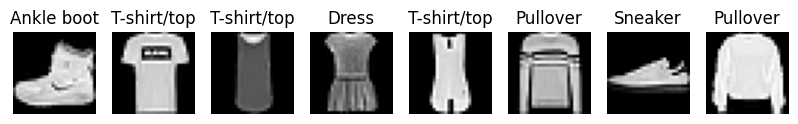

In [278]:
# Візуалізуємо декілька зображень та їх міток
def visualize_images(images, labels, labels2index, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels2index[labels[i]])
        plt.axis('off')
    plt.show()

num_images_to_visualize = 8
visualize_images(train_images, train_labels, labels2index, num_images=num_images_to_visualize)

### Підготуємо дані для моделі, використовуючи універсальний класс Dataset

In [279]:
# Переведемо дані зображень в діапазон [0, 1]
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Перетворимо мітки класів у one-hot кодування
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [280]:
# Перетворимо тренувальні та тестувальні дані у вектори розміром 1 на 784 (кількість пікселів) щоб подати на вхід нейромережі.
# Відповідно, мережа буде сприймати кожен піксель як окремий вхідний параметр для класифікації зображення

train_images = train_images.reshape((-1, 28*28))
test_images = test_images.reshape((-1, 28*28))

In [281]:
train_images.shape, test_images.shape

((60000, 784), (10000, 784))

## Реалізуємо нейромережу та навчимо її

In [282]:
# Побудуємо архітектуру мережі: 3 шари з num_features, num_features*2 та num_classes нейронами відповідно
model = Sequential()
model.add(Dense(units_1, activation='relu', input_shape=(num_features,)))
model.add(Dropout(0.2))
model.add(Dense(units_2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Скомпілюємо модель з оптимізатором, функцією втрат та метрикою оцінки
model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [283]:
# Додамо колбек EarlyStopping, щоб зупинити навчання, якщо точність не покращується протягом певної кількості епох
early_stopping_callback = EarlyStopping(monitor='val_categorical_accuracy', patience=5, mode='max', verbose=1)

# Додамо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', save_best_only=True, verbose=1)


In [284]:
# Навчімо модель
history = model.fit(
    train_images,
    train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1,
    callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]
    )

Epoch 1/50
106/106 [==============================] - ETA: 0s - loss: 0.6354 - categorical_accuracy: 0.7774
Epoch 1: val_categorical_accuracy improved from -inf to 0.85083, saving model to best_model.h5
106/106 [==============================] - 7s 63ms/step - loss: 0.6354 - categorical_accuracy: 0.7774 - val_loss: 0.4253 - val_categorical_accuracy: 0.8508
Epoch 2/50
105/106 [============================>.] - ETA: 0s - loss: 0.4177 - categorical_accuracy: 0.8501
Epoch 2: val_categorical_accuracy improved from 0.85083 to 0.86633, saving model to best_model.h5
106/106 [==============================] - 9s 88ms/step - loss: 0.4178 - categorical_accuracy: 0.8500 - val_loss: 0.3719 - val_categorical_accuracy: 0.8663
Epoch 3/50
105/106 [============================>.] - ETA: 0s - loss: 0.3700 - categorical_accuracy: 0.8670
Epoch 3: val_categorical_accuracy improved from 0.86633 to 0.87117, saving model to best_model.h5
106/106 [==============================] - 8s 77ms/step - loss: 0.3703 - 

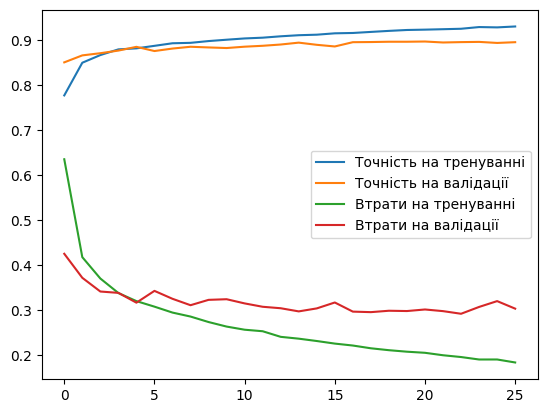

In [285]:
# Графіки для точності та втрат
plt.plot(history.history['categorical_accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_categorical_accuracy'], label='Точність на валідації')
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [286]:
# Завантажимо найкращу модель з колбека ModelCheckpoint
best_model = Sequential()
best_model.add(Dense(units_1, activation='relu', input_shape=(num_features,)))
best_model.add(Dropout(0.2))
best_model.add(Dense(units_2, activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(num_classes, activation='softmax'))
best_model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
best_model.load_weights('best_model.h5')

In [287]:
# Оцінимо найкращу модель на тестовому наборі даних
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f'Точність на тестовому наборі: {test_accuracy}')

313/313 [==============================] - 2s 6ms/step - loss: 0.3163 - categorical_accuracy: 0.8922
Точність на тестовому наборі: 0.8921999931335449


## Проведемо роботу над помилками

313/313 [==============================] - 1s 3ms/step


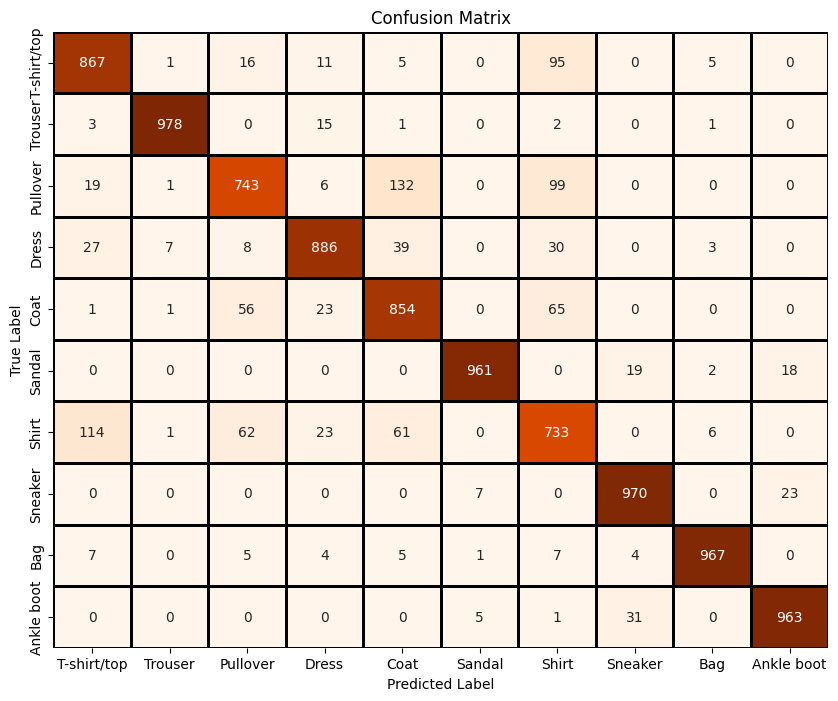

In [288]:
# Побудуємо матрицю плутанини
predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, predicted_label in zip(np.argmax(test_labels, axis=1), predicted_labels):
    confusion_matrix[true_label, predicted_label] += 1

# Відобразимо heatmap матриці плутанини з seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix,  fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

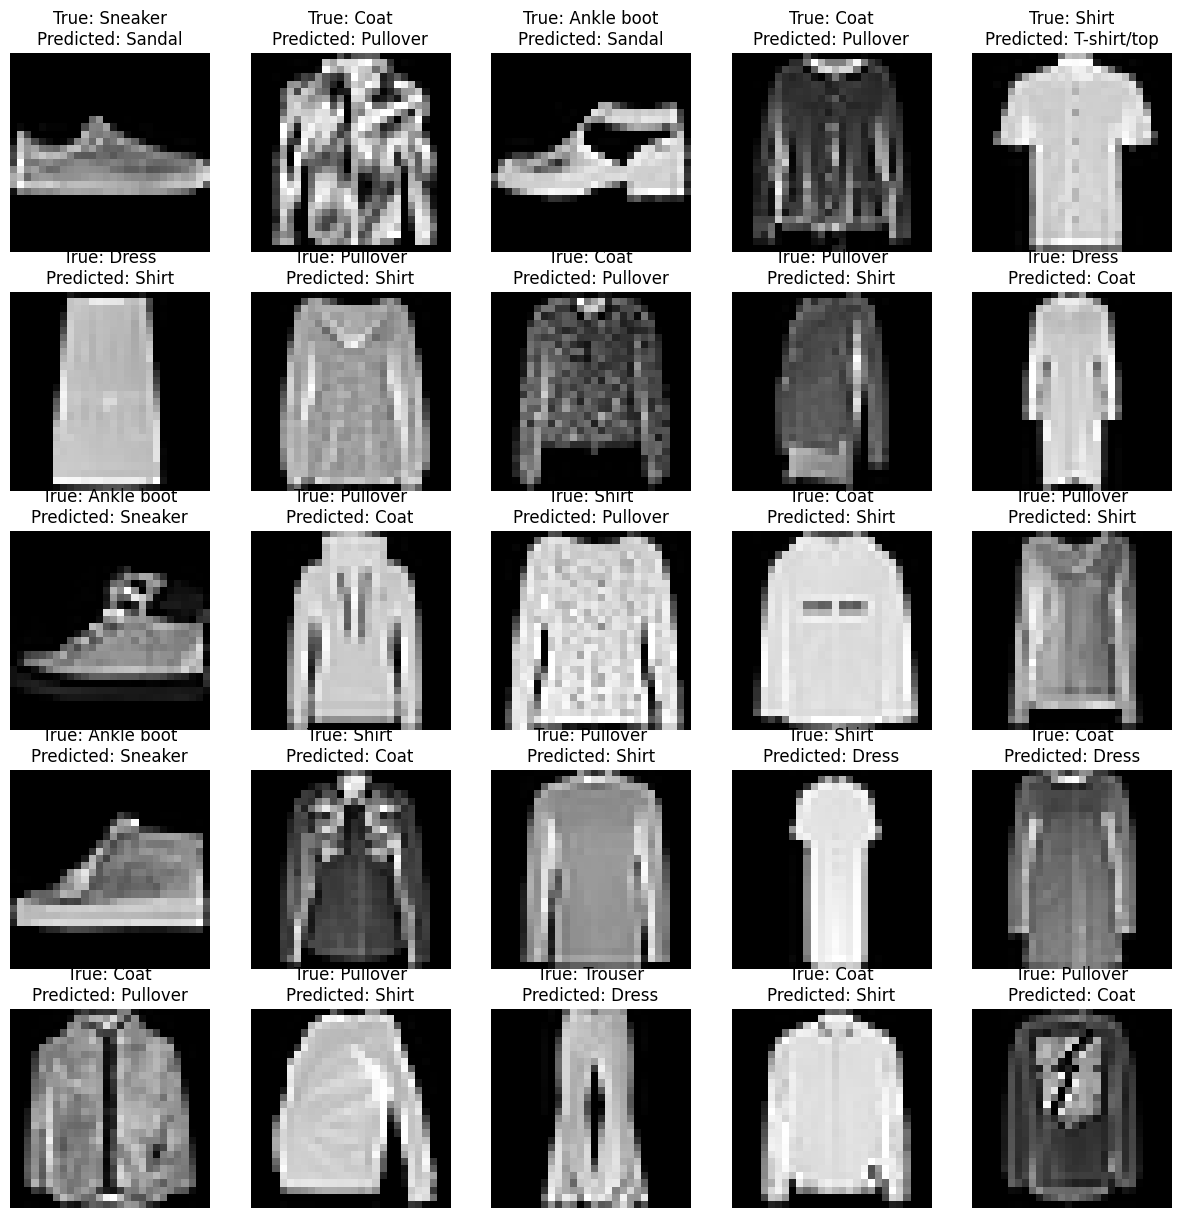

In [289]:
# Знайдемо невірно класифіковані зображення
incorrect_indices = np.where(predicted_labels != np.argmax(test_labels, axis=1))[0]

# Виведемо графік 5x5 зображень невірно класифікованих зображень разом з мітками
plt.figure(figsize=(15, 15))
for i, idx in enumerate(incorrect_indices[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[idx].reshape((28, 28)), cmap='gray')  # Перетворимо назад в форму (28, 28)
    plt.title('True: {}\nPredicted: {}'.format(labels[np.argmax(test_labels[idx])], labels[predicted_labels[idx]]))
    plt.axis('off')
plt.show()

In [290]:
# Загальна кількість невлучних передбачень
incorrect_indices.shape

(1078,)

## Спробуємо побудувати альтернативну модель, використовуючи додатковий вбудований пакет

In [291]:
!pip install keras-tuner

In [292]:
from kerastuner.tuners import RandomSearch

In [293]:
# Функція для створення моделі
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units', min_value=10, max_value=units_1, step=10), activation='relu', input_shape=(num_features,)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units', min_value=10, max_value=units_2, step=10), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [294]:
# Пошук оптимальних гіперпараметрів
tuner = RandomSearch(
    build_model,
    objective='val_categorical_accuracy',
    max_trials=5,  # Кількість спроб підбору
    directory='keras_tuner_dir',  # Директорія для зберігання результатів
    project_name='fashion_mnist_tuning'  # Назва проекту
)

tuner.search(train_images, train_labels, epochs=n_epochs, validation_split=validation_split)


In [295]:
# Виведення результатів підбору
tuner.results_summary()


Results summary
Results in keras_tuner_dir/fashion_mnist_tuning
Showing 10 best trials
Objective(name="val_categorical_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
units: 512
dropout: 0.30000000000000004
learning_rate: 0.0001
Score: 0.8955000042915344

Trial 1 summary
Hyperparameters:
units: 320
dropout: 0.30000000000000004
learning_rate: 0.0001
Score: 0.8923333287239075

Trial 4 summary
Hyperparameters:
units: 320
dropout: 0.4
learning_rate: 0.001
Score: 0.8851666450500488

Trial 0 summary
Hyperparameters:
units: 320
dropout: 0.2
learning_rate: 0.01
Score: 0.8411666750907898

Trial 3 summary
Hyperparameters:
units: 448
dropout: 0.4
learning_rate: 0.01
Score: 0.7548333406448364


In [296]:
# Отримання найкращої моделі
best_model_tuned = tuner.get_best_models(num_models=1)[0]

# Навчання найкращої моделі
history_tuned = best_model_tuned.fit(train_images, train_labels, epochs=n_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[WandbMetricsLogger()])

Epoch 1/50
106/106 [==============================] - 10s 93ms/step - loss: 0.2028 - categorical_accuracy: 0.9246 - val_loss: 0.2795 - val_categorical_accuracy: 0.8988
Epoch 2/50
106/106 [==============================] - 11s 104ms/step - loss: 0.1933 - categorical_accuracy: 0.9292 - val_loss: 0.2785 - val_categorical_accuracy: 0.8995
Epoch 3/50
106/106 [==============================] - 11s 103ms/step - loss: 0.1908 - categorical_accuracy: 0.9308 - val_loss: 0.2784 - val_categorical_accuracy: 0.8987
Epoch 4/50
106/106 [==============================] - 11s 105ms/step - loss: 0.1882 - categorical_accuracy: 0.9309 - val_loss: 0.2787 - val_categorical_accuracy: 0.8993
Epoch 5/50
106/106 [==============================] - 8s 71ms/step - loss: 0.1871 - categorical_accuracy: 0.9321 - val_loss: 0.2787 - val_categorical_accuracy: 0.9000
Epoch 6/50
106/106 [==============================] - 5s 47ms/step - loss: 0.1860 - categorical_accuracy: 0.9323 - val_loss: 0.2806 - val_categorical_accuracy

In [297]:
# Оцінимо найкращу модель на тестовому наборі даних
test_loss_tuned, test_accuracy_tuned = best_model_tuned.evaluate(test_images, test_labels)
print(f'Точність на тестовому наборі: {test_accuracy_tuned}')

313/313 [==============================] - 3s 9ms/step - loss: 0.3162 - categorical_accuracy: 0.8993
Точність на тестовому наборі: 0.8992999792098999


# Візуалізація запусків на моніторі wandb
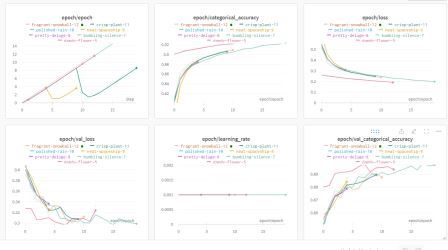

## Висновки:
до 25 епох:
Побудована нейромережа після підбору параметрів видає точність в діапазоні 88-89% на тестових даних.

Альтернативна нейромережа (kerastuner) видає 89,7% на тестових даних.

В обох випадках валідаційний скор +1%, тобто невеликий оверфіт.

З рістом епох до 50: точність +0,2%, але вдвічі довше, тому не має сенсу